In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import Config
from datetime import datetime
from img_embedding import ImageEmbedding
from img_transformer import ImgTransformer
from img_util import show_img_tensor_CHW
from fliker_comment_tokenizer import FlikerCommentTokenizer
from fliker_img_comment_dataset import ImgCommentDataset
from model_util import count_parameters
from pathlib import Path
from text_token_embedding import TextTokenEmbedding
from text_casual_mask_transformer import TextMaskedTransformer
from torch.utils.tensorboard import SummaryWriter


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import DataLoader
import torchvision.transforms.functional as VF



plt.rcParams["savefig.bbox"] = 'tight'

/opt/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = Config()

train_dataset = ImgCommentDataset(config, split="train")
eval_dataset = ImgCommentDataset(config, split="eval")
test_dataset= ImgCommentDataset(config, split="test")
print(f"train_dataset:  {len(train_dataset)}")
print(f"eval_dataset:  {len(eval_dataset)}")
print(f"test_dataset:  {len(test_dataset)}")


# Data Loader
BATCH_SIZE = 20
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"train_dataloader:  {len(train_dataloader)}")
print(f"eval_data_loader:  {len(eval_dataloader)}")
print(f"test_data_loader:  {len(test_dataloader)}")


Enriched img id: /tmp/enriched_results.csv
tokens: 128000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 128000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 128000
tokenizer.is_fast: True
train_dataset:  114418
eval_dataset:  28605
test_dataset:  15892
train_dataloader:  5721
eval_data_loader:  1431
test_data_loader:  795


In [3]:
class ImgCaptionModel(nn.Module):
    def __init__(self, config: Config, tokenizer):
        super().__init__()

        assert config is not None
        assert config.img_patch_embedding == config.text_token_embedding, f"img_patch_embedding: {config.img_patch_embedding} should be same as text_token_embedding: {config.text_token_embedding}"

        self.config = config        
        self.tokenizer = tokenizer

        # ---------------------------------------------------------
        # [<imge> x IMG_PATCHES][<bos>][TEXT_TOKEN_EMB x N][<pad>*]
        # ---------------------------------------------------------
        #           i0  i1  b   t1  t2  t3
        # <image> | 1,  1,  1,  1,  1,  1 |
        # <image> | 1,  1,  1,  1,  1,  1 | 
        # <bos>   | 1,  1,  1,  1,  1,  1 |
        # t1      | 1,  1,  1,  1,  0,  0 |
        # t2      | 1,  1,  1,  1,  1,  0 |
        # t3      | 1,  1,  1,  1,  1,  1 |
        self.img_bos_mask = torch.ones(size=(config.img_patches + 1, config.img_patches + 1 + config.max_text_len)) # (IMG_PATCHES + 1) x (IMG_PATCHES + 1 + TEXT_TOKENS)
        self.text_mask = torch.hstack([
            torch.ones(size=(config.max_text_len, config.img_patches + 1)),
            torch.tril(torch.ones(size=(config.max_text_len, config.max_text_len)))
        ])
        self.mask = torch.vstack([self.img_bos_mask, self.text_mask])
        self.transformer = TextMaskedTransformer(config=config, mask=self.mask)
        self.lm_head = nn.Linear(config.text_token_embedding, tokenizer.vocab_size, bias=False)

    def forward(self, img_feature: torch.tensor, text_feature: torch.tensor, text_mask: torch.tensor, target_text_token: torch.tensor, bos_embedding: torch.tensor): 
        """
        inputs:
            - img_feature: B x IMG_PATCHES x IMG_PATCH_EMB
            - text_feature: B x TEXT_TOKEN x TEXT_EMB
            - text_mask: B x TEXT_TOKEN x 1
            - target_text_token: B x TEXT_TOKEN
        outputs:
            - text prediction: 
            - loss
        """
        bos_embedding = bos_embedding.view(1, 1, -1) # 1 x 1 x TEXT_EMB
        bos_embedding = bos_embedding.to(img_feature.device)
        assert len(img_feature.size()) == len(bos_embedding.size()) == len(text_feature.size())
        bos_embedding_ext = bos_embedding.expand(img_feature.size()[0], -1, -1)
        x = torch.cat([img_feature, bos_embedding_ext, text_feature], dim=1) # B x [IMG_PATCHES + 1 + TEXT_TOKEN] x IMG_PATCH_EMB
        x = self.transformer(x=x, need_embedding=False) # B x [IMG_PATCHES + 1 + TEXT_TOKEN] x IMG_PATCH_EMB
        x =  self.lm_head(x) # B x [IMG_PATCHES + 1 + TEXT_TOKEN] x vocab_size

        if target_text_token is None:
            loss = None
        else:
            # extract the last `self.config.max_text_len` token positions
            text_pos_mask = torch.arange(start=-50, end=0, step=1)
            text_logits = x[:, text_pos_mask, :] # B x TEXT_TOKEN x vocab_size
            B, TEXT_TOKEN, vocab_size = text_logits.size()
            text_logits = text_logits.view(B*TEXT_TOKEN, -1)
            target_text_token = target_text_token.view(B*TEXT_TOKEN)
            loss = F.cross_entropy(text_logits, target_text_token)

        return text_logits, loss


class ImgLanguageModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config

        self.img_embedding = ImageEmbedding(config=config)
        self.img_transfomer = ImgTransformer(config=config)
        self.img_flatten = nn.Flatten(start_dim=1)
        self.img_proj = nn.Linear(in_features=config.img_patches* config.img_patch_embedding, out_features=config.img_text_proj_features)
        self.img_softmax = nn.LogSoftmax(dim=-1)

        # self.text_embedding = TextTokenEmbedding(config=config)
        self.text_transformer = TextMaskedTransformer(config=config)
        self.text_flatten = nn.Flatten(start_dim=1)
        self.text_proj = nn.Linear(in_features=config.max_text_len* config.text_token_embedding, out_features=config.img_text_proj_features)
        self.text_softmax = nn.LogSoftmax(dim=-1)
        
        self.diag_mask = torch.diag(torch.ones(config.img_text_proj_features))
        self.loss_fn = nn.NLLLoss()

        self.bos_token = self.text_transformer.text_token_embedding.text_encoder.encode("<bos>")[1]  # return <bos><bos>
        self.img_caption_model = ImgCaptionModel(config=config, tokenizer=self.text_transformer.text_token_embedding.text_encoder)

    def forward(self, batch_img_tensor: torch.tensor, batch_text_tensor: torch.tensor, batch_img_id_tensor: torch.tensor=None):
        """
        batch_img_tensor: B x IMG_PATCHES x IMG_EMB
        batch_text_tensor: B x TEXT_TOKEN
        """
        img_embedding = self.img_embedding(batch_img_tensor) # B x IMG_PATCHES x IMG_EMB
        # print(f"img_encoding: {img_embedding.size()}")

        img_feature = self.img_transfomer(img_embedding) # B x IMG_PATCHES x IMG_EMB
        # print(f"img_feature: {img_feature.size()}")

        img_feature_flatten = self.img_flatten(img_feature)
        # print(f"img_feature_flatten: {img_feature_flatten.size()}")

        img_feature_proj = self.img_proj(img_feature_flatten)
        # print(f"img_feature_proj: {img_feature_proj.size()}")  # B x img_text_proj_features

        # text_embedding = self.text_embedding(batch_text_tensor)
        # print(f"text_embedding: {text_embedding.size()}")

        text_feature = self.text_transformer(batch_text_tensor)
        # print(f"text_feature: {text_feature.size()}")

        text_feature_flatten = self.text_flatten(text_feature)
        # print(f"text_feature_flatten: {text_feature_flatten.size()}")

        text_feature_proj = self.text_proj(text_feature_flatten)
        # print(f"text_feature_proj: {text_feature_proj.size()}")  # B x img_text_proj_features

        # Contrastive learning
        contrastive_scores = img_feature_proj @ text_feature_proj.T
        # print(f"contractive_scores: {contrastive_scores}")  # B x img_text_proj_features

        img_contrastive_prob = self.img_softmax(contrastive_scores)
        # print(f"img_contrastive_prob: {img_contrastive_prob}")  # B x img_text_proj_features
        
        target = torch.arange(img_contrastive_prob.size()[0], device=img_contrastive_prob.device)
        img_loss = self.loss_fn(img_contrastive_prob, target) / img_contrastive_prob.size()[0]
        # img_loss = self.loss_fn(img_contrastive_prob, self.target.expand(img_contrastive_prob.size()[0], -1))
        # print(f"img_loss: {img_loss}")

        text_contrastive_prob = self.text_softmax(contrastive_scores.T)
        # print(f"text_contrastive_prob: {text_contrastive_prob}")  # B x img_text_proj_features
        text_loss = self.loss_fn(text_contrastive_prob, target)  / text_contrastive_prob.size()[0]
        # print(f"text_loss: {text_loss}")

        bos_embedding = self.text_transformer.text_token_embedding(torch.tensor(self.bos_token, device=batch_img_tensor.device)) 
        lm_logits, lm_loss = self.img_caption_model(img_feature=img_feature, text_feature=text_feature, text_mask=(batch_text_tensor!=0), target_text_token=batch_text_tensor, bos_embedding=bos_embedding)
        # print(f"lm_logits: {lm_logits.size()}")
        # print(f"lm_loss: {lm_loss}")
        
        return img_loss, text_loss, img_contrastive_prob, text_contrastive_prob, lm_loss, lm_logits

In [4]:
# train_dataset = ImgCommentDataset(config, split="train")

# BATCH_SIZE = 10
# train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

batch_img_tensor, batch_img_id_tensor, batch_comment_encoding, batch_comment_mask = next(iter(train_dataloader))
print(f"batch_img_tensor: {batch_img_tensor.size()}")
print(f"batch_img_id_tensor: {batch_img_id_tensor.size()}")
print(f"batch_comment_encoding: {batch_comment_encoding.size()}")
print(f"batch_comment_mask: {batch_comment_mask.size()}")

batch_img_tensor: torch.Size([20, 3, 224, 224])
batch_img_id_tensor: torch.Size([20])
batch_comment_encoding: torch.Size([20, 50])
batch_comment_mask: torch.Size([20, 50])


In [5]:
model = ImgLanguageModel(config=config)
img_loss, text_loss, img_contrastive_prob, text_contrastive_prob, lm_loss, lm_logit = model(batch_img_tensor=batch_img_tensor, batch_text_tensor=batch_comment_encoding, batch_img_id_tensor=batch_img_id_tensor)
print(f"img_loss: {img_loss}")
print(f"text_loss: {text_loss}")
print(f"lm_loss: {lm_loss}")

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"pytorch_total_params: {pytorch_total_params/10**6} m")
print(f"pytorch_total_trainable_params: {pytorch_total_trainable_params/10**6} m")
count_parameters(model)

tokens: 128000
tokenizer.is_fast: True
tokens: 128000
tokenizer.is_fast: True
img_loss: 0.47136035561561584
text_loss: 0.31149011850357056
lm_loss: 11.313753128051758
pytorch_total_params: 568.73676 m
pytorch_total_trainable_params: 568.73676 m
+------------------------------------------------------------------------+------------+
|                                Modules                                 | Parameters |
+------------------------------------------------------------------------+------------+
|                       img_embedding.conv.weight                        |   559104   |
|                        img_embedding.conv.bias                         |    728     |
|                   img_embedding.pos_embedding.weight                   |   142688   |
|         img_transfomer.blocks.0.multihead_attention.wq.weight          |   529984   |
|          img_transfomer.blocks.0.multihead_attention.wq.bias           |    728     |
|         img_transfomer.blocks.0.multihead_attenti

568736760

In [6]:
logits = torch.rand(size=(5, 10))
target = torch.arange(5)
print(f"logits = {logits.size()}")
print(f"target = {target.size()}")
F.cross_entropy(logits, target)
lm_logit.size()
device = torch.device("mps")
class TM(nn.Module):
    def __init__(self):
        super().__init__()
        self.v = nn.Embedding(1, 2)

tm = TM()
tv = tm.v(torch.tensor(0))
tv
tm = tm.to(device)
tv1 = tm.v(torch.tensor(0, device=device))
tv1

logits = torch.Size([5, 10])
target = torch.Size([5])


tensor([0.4884, 0.2104], device='mps:0', grad_fn=<EmbeddingBackward0>)

In [8]:
EPOCHES = 5
EVAL_INTERVAL = 100
EVAL_STEPS = 10
lr = 0.001

device = torch.device("mps")

model = model.to(device)
optimizer =  torch.optim.AdamW(params=model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=EPOCHES)

def eval(model: ImgLanguageModel, global_step : int, writer: SummaryWriter):
    model.eval()

    avg_eval_loss = None
    eval_loss_std = None
    with torch.no_grad():
        eval_losses = []
        for i, data in enumerate(eval_dataloader):
            if i > EVAL_STEPS:
                # It takes significant time to do one full eval.
                break

            batch_img_tensor, batch_img_id_tensor, batch_target_tensor, batch_target_mask = data
            batch_img_tensor = batch_img_tensor.to(device)
            batch_img_id_tensor = batch_img_id_tensor.to(device)
            batch_target_tensor = batch_target_tensor.to(device)
            batch_target_mask = batch_target_mask.to(device)
            img_loss, text_loss, img_contrastive_prob, text_contrastive_prob, lm_loss, lm_logit = model(batch_img_tensor, batch_target_tensor)
            writer.add_scalar("eval/Img Loss", img_loss, global_step)
            writer.add_scalar("eval/Text Loss", text_loss, global_step)
            writer.add_scalar("eval/LM Loss", lm_loss, global_step)
            eval_losses.append(img_loss + text_loss)
        eval_losses = torch.tensor(eval_losses)
        avg_eval_loss = eval_losses.mean()
        eval_loss_std = eval_losses.std()
        writer.add_scalar("eval/Loss", avg_eval_loss, global_step)
        writer.add_scalar("Loss/eval-std", eval_loss_std, global_step)
    model.train()
    writer.flush()
    return avg_eval_loss, eval_loss_std
    


def train(model: ImgLanguageModel, writer: SummaryWriter):
    best_vloss = torch.tensor(1_000_000)
    with torch.profiler.profile(
            schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
            on_trace_ready=torch.profiler.tensorboard_trace_handler('./runs'),
            activities=[torch.profiler.ProfilerActivity.CPU], 
            record_shapes=True,
            profile_memory=True,
            with_stack=True
    ) as prof:
    # with torch.mps.profiler.profile(mode="interval", wait_until_completed=False):
        for epoch in range(EPOCHES): 
            for train_step, data in enumerate(train_dataloader):
                global_step = epoch * len(train_dataloader) + train_step

                # Profile
                if global_step < 1 + 1 + 3:
                    prof.step()

                batch_img_tensor, batch_img_id_tensor, batch_target_tensor, batch_target_mask = data
                batch_img_tensor = batch_img_tensor.to(device)
                batch_img_id_tensor = batch_img_id_tensor.to(device)
                batch_target_tensor = batch_target_tensor.to(device)
                batch_target_mask = batch_target_mask.to(device)

                # Viz Model
                # if global_step == 0:
                #     writer.add_graph(model, (batch_img_tensor, batch_target_tensor))

                optimizer.zero_grad()
                img_loss, text_loss, img_contrastive_prob, text_contrastive_prob, lm_loss, lm_logit = model(batch_img_tensor, batch_target_tensor)
                writer.add_scalar("train/Img Loss", img_loss, global_step)
                writer.add_scalar("train/Text Loss", text_loss, global_step)
                writer.add_scalar("train/LM Loss", lm_loss, global_step)
                writer.add_scalar("train/Loss", img_loss+text_loss+lm_loss, global_step)
                writer.add_scalar("Learning Rate", scheduler.get_last_lr()[-1], global_step)
                loss = img_loss + text_loss
                loss.backward()
                optimizer.step()
                scheduler.step()

                if train_step > 0 and train_step % EVAL_INTERVAL == 0:
                    avg_vloss, _ = eval(model=model, global_step=global_step, writer=writer)
                
                    if avg_vloss is not None and avg_vloss < best_vloss:
                        best_vloss = avg_vloss
                        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                        model_path = f"vlm_caption_model_{epoch}_{timestamp}"
                        torch.save(model.state_dict(), model_path)

with SummaryWriter(flush_secs=1) as writer:
    train(model=model, writer=writer)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = f"vlm_caption_model_{timestamp}_final"
    torch.save(model.state_dict(), model_path)

STAGE:2024-08-30 14:11:25 63895:6789444 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2024-08-30 14:11:33 63895:6789444 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-08-30 14:11:33 63895:6789444 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [9]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f"vlm_contrastive_model_0_{timestamp}_final"
torch.save(model.state_dict(), model_path)

In [10]:
model_trained = ImgLanguageModel(config=config)
model_trained.load_state_dict(torch.load(model_path))
model_trained = model_trained.to(device)
model_trained.eval()


tokens: 128000
tokenizer.is_fast: True
tokens: 128000
tokenizer.is_fast: True


ImgLanguageModel(
  (img_embedding): ImageEmbedding(
    (conv): Conv2d(3, 728, kernel_size=(16, 16), stride=(16, 16), padding=valid)
    (pos_embedding): Embedding(196, 728)
  )
  (img_transfomer): ImgTransformer(
    (blocks): Sequential(
      (0): ImgTransformerBlock(
        (multihead_attention): ImgMultiheadSelfAttention(
          (wq): Linear(in_features=728, out_features=728, bias=True)
          (wk): Linear(in_features=728, out_features=728, bias=True)
          (wv): Linear(in_features=728, out_features=728, bias=True)
          (norm): LayerNorm((728,), eps=1e-05, elementwise_affine=True)
          (softmax): Softmax(dim=-1)
        )
        (norm): LayerNorm((728,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=728, out_features=2912, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2912, out_features=728, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
     

In [19]:
batch_img_tensor, batch_img_id_tensor, batch_target_tensor, batch_target_mask_tensor = next(iter(test_dataloader))
batch_img_tensor = batch_img_tensor.to(device)
batch_target_tensor = batch_target_tensor.to(device)
batch_target_mask_tensor = batch_target_mask_tensor.to(device)
img_loss, text_loss, img_contrastive_prob, text_contrastive_prob, lm_loss, lm_logit  = model_trained(batch_img_tensor, batch_target_tensor)


tensor(73.3803, device='mps:0', grad_fn=<DivBackward0>)


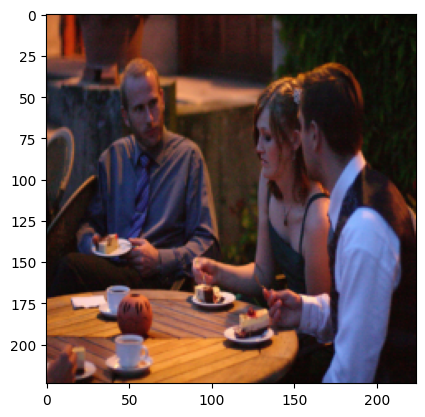

In [20]:
print(img_loss)
show_img_tensor_CHW(batch_img_tensor[19].cpu())

In [21]:
torch.argmax(img_contrastive_prob, dim=0)

tensor([ 7,  0, 11, 13, 17, 18, 11, 14,  8, 11,  3, 11, 13,  4,  0,  1,  2, 16,
         3, 14], device='mps:0')

In [22]:
model_trained.text_transformer.text_token_embedding.text_encoder.decode(batch_target_tensor[19])

'<bos>A group of friends enjoy desert .<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [23]:
def show(imgs, comments, labels):
    if not isinstance(imgs, list):
        imgs = [imgs]
    imgs_per_row = 1
    fix, axs = plt.subplots(nrows=(len(imgs)+imgs_per_row-1)//imgs_per_row, ncols=imgs_per_row, squeeze=False, figsize=(16,60))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        row = i // imgs_per_row
        col = i % imgs_per_row
        axs[row, col].imshow(np.asarray(img))
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        title = f'pred: {comments[i].replace("<pad>", "").replace("<bos>", "")}\nlabel: {labels[i].replace("<pad>", "").replace("<bos>", "")}'
        axs[row, col].set_title(title)
        

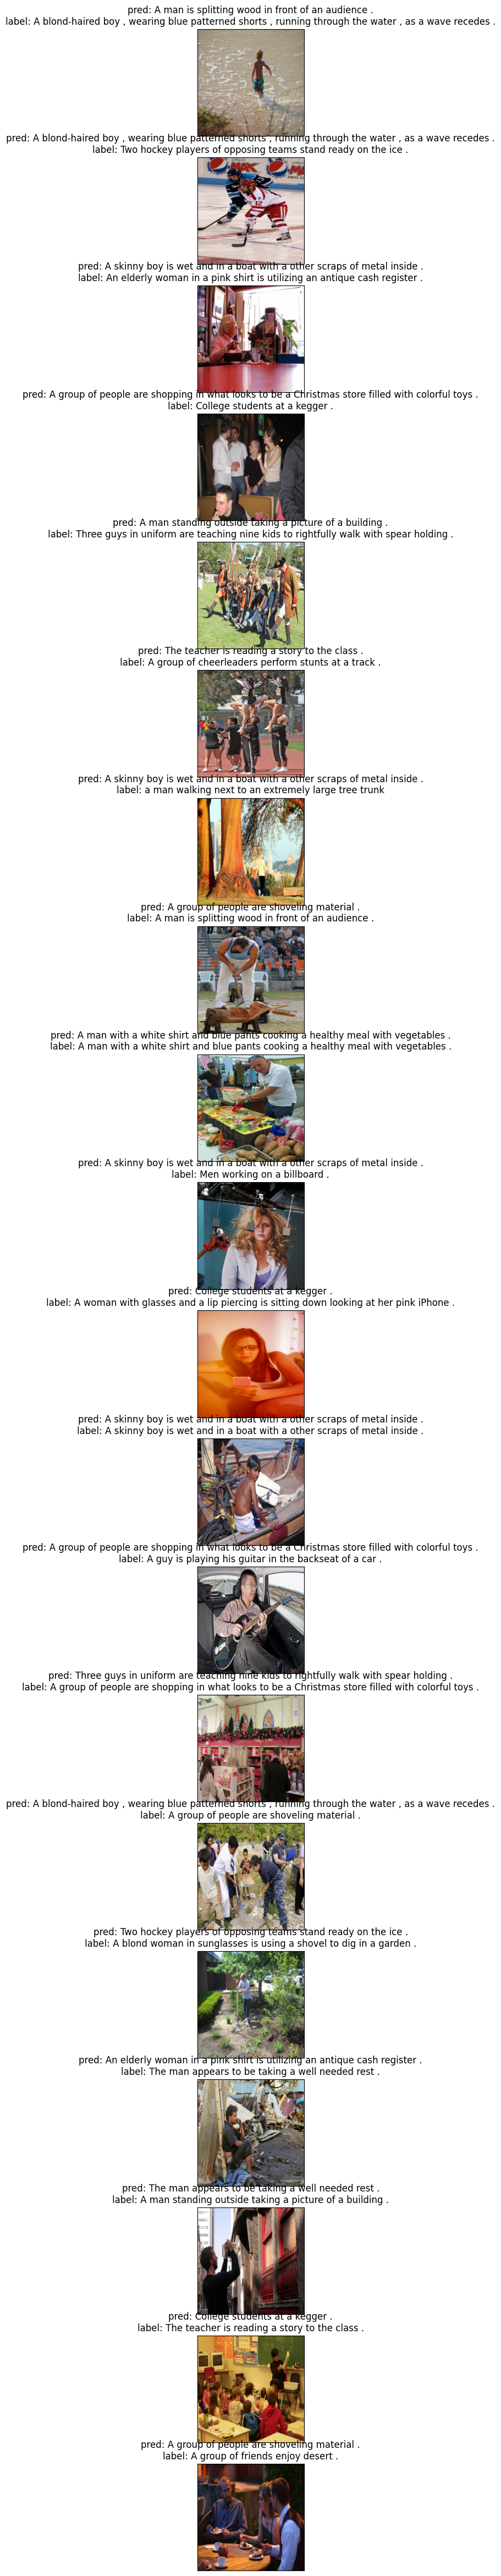

In [24]:
img_predicted_commments_index = torch.argmax(img_contrastive_prob, dim=0)

show(imgs = [img for img in batch_img_tensor.cpu()], 
     labels = [model_trained.text_transformer.text_token_embedding.text_encoder.decode(target_tensor) for target_tensor in batch_target_tensor],
     comments = [model_trained.text_transformer.text_token_embedding.text_encoder.decode(batch_target_tensor[predicted_comment_index]) for predicted_comment_index in img_predicted_commments_index],
     )
